## Exploration

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# print("train.csv shape is ", trainingSet.shape)
# print("test.csv shape is ", testingSet.shape)

# print()

# print(trainingSet.head())
# print()
# print(testingSet.head())

# print()

# print(trainingSet.describe())
trainingSet['Score'].value_counts()
indexes = trainingSet[trainingSet.Score == 5].sample(frac=0.4).index
trainingSet = trainingSet.drop(indexes)
trainingSet['Score'].value_counts()

# trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
# plt.title("Count of Scores")
# plt.show()

# trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 most rated Products")
# plt.show()

# trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 least rated Products")
# plt.show()

# trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 Reviewers")
# plt.show()

# trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
# plt.title("Lowest 25 Reviewers")
# plt.show()

# trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
# plt.title("Mean Helpfulness Numerator per Score")
# plt.show()

# trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 best rated Products")
# plt.show()

# trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 worst rated Products")
# plt.show()

# trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 kindest Reviewers")
# plt.show()

# trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
# plt.title("Top 25 harshest Reviewers")
# plt.show()

# trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
# plt.title("Mean of top 25 most rated Products")
# plt.show()



5.0    40313
4.0    28572
3.0    14857
1.0     7593
2.0     7567
Name: Score, dtype: int64

In [9]:
# ideas:
# for top reviewers, do they review things for similar rating? what is the mean of the rating for each
# reviewer? how concentrated are the review for each top reviewer? try to extract words/numbers from their reviews

# for reviews, what are the key words? sometimes they state the rating number in the review

# for top most rated products, what is the concentration of the rating? how about the rating for 
# products that are similar? any relations? 

# extract key words for each rating


## Feature Extraction

HERE BEGINS THE PREPROCESSING

4288
0.1352724060695921


count    31699.000000
mean         0.641046
std          0.294759
min          0.000000
25%          0.400000
50%          0.714286
75%          0.888889
max          1.000000
Name: Helpfulness, dtype: float64

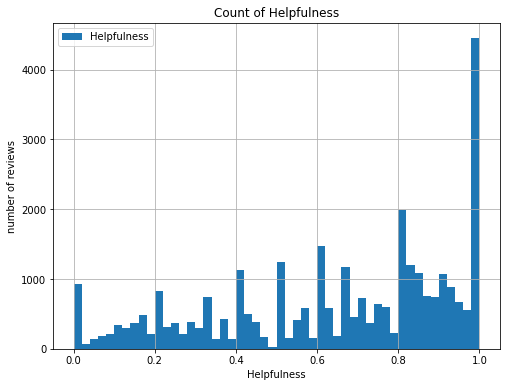

In [260]:
train1['Helpfulness'] = train1['HelpfulnessNumerator'] / train1['HelpfulnessDenominator']
train1['Helpfulness'] = train1['Helpfulness'].fillna(0)
#remove the outlier in Helpfulness(row with Helpfulness=8)
train1=train1.loc[train1['Helpfulness']<=1.0]
count=(train1['Helpfulness'] == 1.0).sum()
print(count)
print(count/len(train1))
hist = train1['Helpfulness'].hist(bins=50,figsize=(8, 6),legend=True)
plt.ylabel("number of reviews")
plt.xlabel("Helpfulness")
plt.title("Count of Helpfulness")
train1['Helpfulness'].describe()
# plt.savefig('count_of_helpfulness.jpg')

In [58]:
import pandas as pd
import numpy as np
import copy
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from collections import Counter
import re
import string

def process(df):
    # This is where you can do all your processing

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
    product_occurrence = pd.DataFrame(df.ProductId.value_counts()).reset_index()
    product_occurrence = product_occurrence.rename(columns={"index": "ProductId", "ProductId": "ProductOccurence"})
    df=df.merge(product_occurrence,on='ProductId')
    users_reviews_count = df.UserId.value_counts()
    users_reviews_count = users_reviews_count.to_frame(name='UserReviewsCount').reset_index().rename(columns={'index': 'UserId'})
    df = df.merge(users_reviews_count)
    #time
    

    df['dob'] = pd.to_datetime(df.Time, unit='s')
    df['year'] = df.dob.dt.year
    df['month'] = df.dob.dt.month
    df['day'] = df.dob.dt.day
    df['Age'] = df["dob"].apply(lambda x : (pd.datetime.now().year - x.year))

    #text preprocess
    df=df.astype({"Text": 'str', "Summary": 'str'})
    df['SummaryUppercaseCount'] = df['Summary'].apply(count_uppercase)
    df['SummaryExclamationCount'] = df['Summary'].apply(count_exclamation_marks)
    df['ReviewUppercaseCount'] = df['Text'].apply(count_uppercase)
    df['ReviewExclamationCount'] = df['Text'].apply(count_exclamation_marks)
    df['ReviewQuestionCount'] = df['Text'].apply(count_question_marks)
    df['ReviewPunctuationCount'] = df['Text'].apply(count_punctuation)
    df['SummaryPunctuationCount'] = df['Summary'].apply(count_punctuation)
    df['ReviewDigitCount'] = df['Text'].apply(count_digits)
    df['SummaryDigitCount'] = df['Summary'].apply(count_digits)

    #remove punctuation
    p = re.compile(r'[^\w\s]+')
    df['Text'] = [p.sub('', x) for x in df['Text'].tolist()]
    df['Text'] = df['Text'].str.lower().str.split()
    # remove stop words
    stopW = ['would','i','it','as','with','was','with','but','you','are','film','movie','one','get','see','even','story','first','much','also','in','on','of','to','a','an','the','and','this','that','is']
  
    df['Text'] = df['Text'].apply(lambda x: [item for item in x if item not in stopW] if isinstance(x, list) else np.nan)
    df['Text'] = df['Text'].apply(', '.join)
    p1 = re.compile(r'[^\w\s]+')
    df['Text'] = [p1.sub('', x) for x in df['Text'].tolist()]
    df['Text'] = df['Text'].str.lower()

    # df['Sentiment'] = df['Text'].apply(get_sentiment)
    df[['Neg', 'Neu', 'Pos', 'Compound']] = df['Text'].agg(get_sentiment).apply(pd.Series)


    return df

#helper functions for text
def count_uppercase(text):
    return sum(1 for char in text if char.isupper())

def count_lowercase(text):
    return sum(1 for char in text if char.islower())
def count_exclamation_marks(text):
    return sum([1 for char in text if char == '!'])

def count_question_marks(text):
    return sum([1 for char in text if char == '?'])

def count_punctuation(text):
    return sum([1 for char in text if char in string.punctuation])

def count_digits(text):
    return sum([1 for char in text if char.isdigit()])

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return tuple(sentiment.values())



# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

#drop rows with score=5 and cut down the 60% of number of rows of socre 5 to save time
indexes = trainingSet[trainingSet.Score == 5].sample(frac=0.4).index
trainingSet = trainingSet.drop(indexes)

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]
trainX.head(10)
#******************drop rows#######################
#drop duplicates
features_subset =trainX.columns[1:]  # Remove index
trainX.drop_duplicates(features_subset, keep='first')




# trainX=trainX.loc[trainX['ReviewLength'] < 3000]
#make a copy 
# train1 = copy.deepcopy(trainX)
#drop rows where HelpfulnessDenominator <2
# trainX =  trainX[trainX['HelpfulnessDenominator']>0]

#remove the outlier in Helpfulness(row with Helpfulness=8)
trainX=trainX.loc[trainX['Helpfulness']<=1.0]
# trainX=trainX.loc[trainX['Helpfulness']>=0.1]
# count=(trainX['Helpfulness'] == 0).sum()
# print(count)
# print(count/len(trainX))

# graphs for helpfulness
# hist = trainX['Helpfulness'].hist(bins=50,figsize=(8, 6),legend=True)
# plt.ylabel("number of reviews")
# plt.xlabel("Helpfulness")
# plt.title("Count of Helpfulness")
# trainX['Helpfulness'].describe()
# trainX
# hist = trainX['UserReviewsCount'].hist(bins=50,figsize=(8, 6),legend=True)
# plt.ylabel("number of reviews")
# plt.xlabel("reviewer")
# plt.title("Count of reviews per reviewer")
# trainX['UserReviewsCount'].describe()



#removes rows with product_occurrence<=14

# product_occurrence['ProductOccurence'].nlargest
# train1.nlargest(5, ['ProductOccurence'])
# train1

# hist = train1['ProductOccurence'].hist(bins=50,figsize=(8, 6),legend=True)
# train1['ProductOccurence'].describe()

# trainX=trainX.loc[trainX['ProductOccurence'] >= 3]

# hist = train1['ProductOccurence'].hist(bins=50,figsize=(8, 6),legend=True)
# trainX['ProductOccurence'].describe()


# len(train1)


/var/folders/yy/pdmswf251qs2tdymzfxsjbj40000gn/T/ipykernel_12105/2888602080.py:31: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['Age'] = df["dob"].apply(lambda x : (pd.datetime.now().year - x.year))


In [415]:

trainX['Text'] = trainX['Text'].apply(', '.join)

trainX.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Helpfulness,ReviewLength,ProductOccurence,UserReviewsCount,SummaryUppercaseCount,SummaryExclamationCount,ReviewUppercaseCount,ReviewExclamationCount,ReviewQuestionCount
0,1049849,B000MR9D5E,A1EKSETIBS9ETQ,0,0,1198281600,"Great nature series, but not all scenes looked...","have, watched, numbers, nature, shows, series,...",4.0,0.0,165,38,2,2,0,24,0,0
1,1007407,B000GUJYZQ,A1EKSETIBS9ETQ,1,1,1167609600,High Def is the way to go.,"best, looking, cg, animation, highdef, date, s...",5.0,1.0,121,23,2,2,0,23,0,0
2,1049776,B000MR9D5E,AZQ7O73EAS3VI,0,1,1285545600,Excellent,"cream, crop, best, nature, show, ever, only, d...",5.0,0.0,46,38,8,1,0,23,3,3
3,1047268,B000MMMT9G,AZQ7O73EAS3VI,0,1,1285545600,Funny,"disgusting, times, hilarious, if, like, sacha,...",4.0,0.0,31,29,8,1,0,9,0,0
4,148915,0792842499,AZQ7O73EAS3VI,2,2,1285545600,excellent,"classic, bd, whats, say, loved, they, did, ter...",5.0,1.0,32,22,8,0,0,12,0,1


In [416]:
p1 = re.compile(r'[^\w\s]+')
trainX['Text'] = [p1.sub('', x) for x in trainX['Text'].tolist()]
trainX['Text'] = trainX['Text'].str.lower()

In [59]:
# trainX.nsmallest(5,['Score'])
 

In [418]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

# def sentiment_analysis(text):

#     sid = SentimentIntensityAnalyzer()
#     sentiment_analysis_scores = sid.polarity_scores(text)
#     return tuple(sentiment_analysis_scores.values())
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

trainX['Sentiment'] = trainX['Text'].apply(get_sentiment)
# trainX

# top_N = 20
# stopwords = stopwords.words('english')
# RE_stopwords = r'[^\w\s]'.format('|'.join(stopwords))
# words = (df.Text
#             .str.lower()
#             .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
#             .str.cat(sep=' ')
#             .split())
# sw_df = pd.DataFrame(Counter(words).most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Helpfulness,ReviewLength,ProductOccurence,UserReviewsCount,SummaryUppercaseCount,SummaryExclamationCount,ReviewUppercaseCount,ReviewExclamationCount,ReviewQuestionCount,Sentiment
0,1049849,B000MR9D5E,A1EKSETIBS9ETQ,0,0,1198281600,"Great nature series, but not all scenes looked...",have watched numbers nature shows series over ...,4.0,0.0,165,38,2,2,0,24,0,0,0.8812
1,1007407,B000GUJYZQ,A1EKSETIBS9ETQ,1,1,1167609600,High Def is the way to go.,best looking cg animation highdef date seen sh...,5.0,1.0,121,23,2,2,0,23,0,0,0.9778
2,1049776,B000MR9D5E,AZQ7O73EAS3VI,0,1,1285545600,Excellent,cream crop best nature show ever only david at...,5.0,0.0,46,38,8,1,0,23,3,3,0.3182
3,1047268,B000MMMT9G,AZQ7O73EAS3VI,0,1,1285545600,Funny,disgusting times hilarious if like sacha doing...,4.0,0.0,31,29,8,1,0,9,0,0,0.2732
4,148915,0792842499,AZQ7O73EAS3VI,2,2,1285545600,excellent,classic bd whats say loved they did terrific j...,5.0,1.0,32,22,8,0,0,12,0,1,0.9531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139311,994144,B000FQISGC,AEZ4DZCUL021H,0,0,1248220800,Two Great Movies together!!!,its great these classics together pack though ...,5.0,0.0,69,1,1,3,3,5,1,0,0.9524
139312,836765,B0002J4X2A,A1YUPHD4AROTJV,1,2,1349568000,Music in my Heart,early years margarita good music just enchanti...,4.0,0.5,48,2,1,2,0,9,0,0,0.8655
139313,1187200,B001F0TT42,A38ARND1KYTU0K,0,0,1365206400,Caught me off guard!,picked up add my collection expecting toss asi...,4.0,0.0,159,1,1,1,1,20,17,0,-0.7670
139315,1173132,B001BQJLF2,A32TM6ED840A63,4,5,1254182400,Judge for yourself.,judge for yourself all movies never really kno...,5.0,0.8,183,1,1,1,0,18,0,5,-0.0497


In [60]:
# trainX
features_interested =['HelpfulnessNumerator','HelpfulnessDenominator','Helpfulness', 'ReviewLength', 'ProductOccurence', 'UserReviewsCount','Score','ReviewUppercaseCount','ReviewExclamationCount','ReviewQuestionCount','SummaryExclamationCount','SummaryUppercaseCount','Compound','Neg','Neu','Pos'
                      ,'year','day','month','Time','Age' ]
correlations = abs(trainX[features_interested].corr()['Score'])

# Print the correlations in descending order
print(correlations.sort_values(ascending=False))

Score                      1.000000
Neg                        0.370475
Compound                   0.356984
Pos                        0.340158
ReviewQuestionCount        0.134004
HelpfulnessDenominator     0.129618
Neu                        0.123914
year                       0.086467
Age                        0.086467
Time                       0.086364
ReviewLength               0.064091
UserReviewsCount           0.064088
SummaryExclamationCount    0.049538
Helpfulness                0.032722
ReviewExclamationCount     0.027896
ReviewUppercaseCount       0.021525
HelpfulnessNumerator       0.021230
ProductOccurence           0.011543
month                      0.008552
day                        0.003940
SummaryUppercaseCount      0.002120
Name: Score, dtype: float64


In [61]:
# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)
# train1.to_csv("./data/X_train1.csv", index=False)
#chi sqaure test of independence: checking confunding, if there is confounding, drop featrues. 
# recommender system 

## Creating your model

In [316]:
list(trainX.columns)

['Id',
 'ProductId',
 'UserId',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Time',
 'Summary',
 'Text',
 'Score',
 'Helpfulness',
 'ReviewLength',
 'ProductOccurence',
 'UserReviewsCount',
 'ReviewUppercaseCount',
 'ReviewExclamationCount',
 'ReviewQuestionCount']

Accuracy on testing set =  0.5543557388983257
RMSE on testing set =  1.006007997441593


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


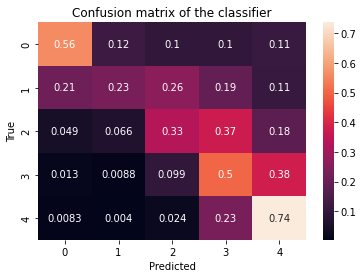

In [62]:

import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")
####################################################

#####################################################
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )
# print(Y_test.shape[0])
# print(X_train.shape[0])
# Y_train = Y_train.astype(int)
# Y_test = Y_test.astype(int)
X_train['Text'] = X_train['Text'].fillna('')
X_test['Text'] = X_test['Text'].fillna('')
X_train['Summary'] = X_train['Summary'].fillna('')
X_test['Summary'] = X_test['Summary'].fillna('')

# tfidf = TfidfVectorizer(stop_words='english', lowercase=True,max_features=93637,max_df=0.5, min_df=0.01)
# tfidf = TfidfVectorizer(stop_words='english', lowercase=True,max_df=0.99999, min_df=0.00007)
tfidf = TfidfVectorizer(stop_words='english', lowercase=True,max_df=0.99983, min_df=0.00008)
# tfidf.fit(X_train['Text'])
# X_train_processed_text = tfidf.fit_transform(X_train['Text'])
# X_test_processed_text = tfidf.transform(X_test['Text'])
# X_train = X_train['Text']
# X_test=X_test['Text']


X_train['text_summary'] = X_train['Text'] + ' ' + X_train['Summary']
X_test['text_summary'] = X_test['Text'] + ' ' + X_test['Summary']
X_train=X_train['text_summary']
X_test=X_test['text_summary']

#********************************test test***************
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
#********************************************************
# tfidf.fit(X_train)
X_train_processed_text = tfidf.fit_transform(X_train)
X_test_processed_text = tfidf.transform(X_test)
# print(X_test_processed_text.shape)



# # This is where you can do more feature selection

# X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId','Text','Summary','dob'])
# X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId','Text','Summary','dob'])


# X_train_combined = sp.hstack((X_train_processed.values, X_train_processed_text))
# X_test_combined = sp.hstack((X_test_processed.values, X_test_processed_text))

#*************************************models*************************************************








# Learn the model

# model = KNeighborsClassifier(n_neighbors=20).fit(X_train_processed, Y_train)
# model = StandardScaler().fit( X_train_processed,Y_train) 
# estimators = []
# model1 = MultinomialNB().fit(X_train_processed,Y_train)
# estimators.append(('Naive Bayes', model1))
# model2 = LinearSVC(random_state=0).fit(X_train_processed,Y_train)
# model2
# estimators.append(('SVM', model2))
# model3 = RandomForestClassifier(bootstrap=True).fit(X_train_processed,Y_train)
# estimators.append(('Random Forest', model3))
#model4 = DecisionTreeClassifier().fit(X_train_processed,Y_train)


# model5 = RandomForestClassifier(n_estimators=100, random_state=35).fit(X_train_processed,Y_train)
model7 = LogisticRegression(C= 5, penalty= 'l2', solver= 'lbfgs').fit(X_train_processed_text,Y_train)
# model7 = LogisticRegression(C= .8, penalty= 'l2', solver= 'lbfgs',max_iter=200).fit(X_train_processed_text,Y_train)
# model7 = LogisticRegression(C= .8, penalty= 'l2', solver= 'saga',max_iter=200).fit(X_train_processed_text,Y_train)
# model7 = LogisticRegression( C= 10, penalty= 'l2', solver= 'saga').fit(X_train_processed_text,Y_train)

# classes =np.unique(Y_train)

# classes:[1,2,3,4,5]
# Y_train = Y_train - 1
# Y_test = Y_test - 1
# model6 = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=1000).fit(X_train_combined, Y_train)




# Use cross-validation to evaluate the model performance across different random states
# random_states = [10, 20, 30, 40, 50]
# scores = {}
# for random_state in random_states:
#     model5.set_params(random_state=random_state)
#     cv_scores = cross_val_score(model5, X_train_processed, Y_train, cv=5)
#     scores[random_state] = cv_scores.mean()
#     scores[random_state] = cv_scores.mean()


# # Print the average score for each random state value
# for random_state, score in scores.items():
#     print(f"Random state: {random_state}, Mean score: {score}")


# create the ensemble model
# ensemble = VotingClassifier(estimators)

# pip_model = Pipeline([('tfidf', TfidfVectorizer()),
#                      ('clf', LinearSVC(dual=False,C = 0.2))])

# pickle model - saves it so you can load it later
# with open('knn_20_model.obj', 'wb') as f:
#         pickle.dump(model, f)
# with open('svm_model.obj', 'wb') as f:
#         pickle.dump(model, f)        
# with open('pip_model.obj', 'wb') as f:
#         pickle.dump(model, f)
# with open('nb_model.obj', 'wb') as f:
#         pickle.dump(model1, f)
# with open('rf_model.obj', 'wb') as f:
#         pickle.dump(model5, f)
with open('lr_model.obj', 'wb') as f:
        pickle.dump(model7, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
# model = pickle.load(f)

# Evaluate your model on the testing set

Y_test_predictions = model7.predict(X_test_processed_text)
# Y_test_predictions.shape[0]
# Y_test_predictions = model7.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions,squared=False))
# print(Y_test.shape[0])
# print(Y_test_predictions.shape[0])
# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [138]:
#recorder of the accuracy:
#1) starter code : 0.5176657656225155; RMSE = 2.1073938622992525
#2) remove occurance(<=14), remove   Accuracy on testing set =  0.5123867069486405; RMSE on testing set =  2.1474638257274608
#3) Accuracy on testing set =  0.21914556962025317; RMSE on testing set =  3.5411392405063293
#4) no coloum removal, with RandomForestClassifier: Accuracy on testing set =  0.4678645253617427; RMSE on testing set =  1.9297185562092543
#5) with occurance, helpfulness and RandomForestClassifier; random state=none: Accuracy on testing set =  0.5012879631101924; RMSE on testing set =  1.7354428366989982
#6) add count of reviews for reviewer: Accuracy on testing set =  0.5231204681338252, RMSE on testing set =  1.6545922910571174
#7) BEST SCORE:add count of equestion, exclamation marks and uppercase count: Accuracy on testing set =  0.5420429970741636; RMSE on testing set =  1.5886973667472333
#8) add sentiment: Accuracy on testing set =  0.560965526014502; RMSE on testing set =  1.4741763134461265
#9)with tf-idf and age of the reviews: Accuracy on testing set =  0.5600750540643684; RMSE on testing set =  1.237672966585792
#10) with tf-idf and logistic regression: Accuracy on testing set =  0.5300897840330017; RMSE on testing set =  1.0429388413699752
#11) with logistic regression and text and summary, c=4: Accuracy on testing set =  0.5529806681226239; RMSE on testing set =  0.9903889836395107
#12) max_df=0.99999, min_df=0.00005: Accuracy on testing set =  0.54881501253741; RMSE on testing set =  0.987567298615886
#13) best:getting 40% of score 5 max_df=0.99999, min_df=0.00007: Accuracy on testing set =  0.5589662703227372; RMSE on testing set =  0.9819613840837917
#14) getting 30% of score 5 max_df=0.99999, min_df=0.00007:Accuracy on testing set =  0.5668623366786594; RMSE on testing set =  0.9975542900694948
#15) getting 60% 5 score: Accuracy on testing set =  0.5230272395394552; RMSE on testing set =  0.9961312414307921
#15) getting 50% 5 score: Accuracy on testing set =  0.5230272395394552; RMSE on testing set =  1.0061211598259863
#16)  getting 30% 5 score: Accuracy on testing set =  0.5672789244461276; RMSE on testing set =  0.9931978462268576, but not working well on kaggle
#17) getting 40% :Accuracy on testing set =  0.5564992315780959; RMSE on testing set =  0.9902256272434238

## Create the Kaggle submission

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer



X_submission = pd.read_csv("./data/X_test.csv")

# # X_submission
# # X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score','dob'])
# X_submission_processed = X_submission['Text']
X_submission['text_summary'] = X_submission['Text'] + ' ' + X_submission['Summary']

X_submission_processed=X_submission['text_summary']

# X_submission_processed
X_submission_processed = X_submission_processed.fillna('')


# # X_test['Text'] = X_test['Text'].fillna('')



# # X_test_processed_text = tfidf.transform(X_test['Text'])

X_submission_processed = tfidf.transform(X_submission_processed)
# X_submission_processed.shape


X_submission['Score'] = model7.predict(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission6.csv", index=False)




# # X_submission['Score'] = model7.predict(X_submission_processed)
# # submission = X_submission[['Id', 'Score']]
# # submission.to_csv("./data/submission2.csv", index=False)

In [111]:
submission.nsmallest(5,['Score'])

,Id,Score
22,893242,1
276,1386238,1
332,1519011,1
597,303877,1
1338,1060244,1


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Helpfulness,ProductOccurence


In [69]:
submission.nlargest(5,'Score')

,Id,Score
6,796418,5.0
16,630653,5.0
17,630633,5.0
22,680809,5.0
67,918222,5.0


Now you can upload the `submission.csv` to kaggle